В данном ноутбуке 
1. Оптимизируем и обучаем LightFM
2. Оптимизируем и обучаем CatBoost
3. Производим сравнение двух моделей

## 💽 Загрузка данных

In [60]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np

In [7]:
# ЗАГРУЗИМ ДАННЫЕ
clients_all = pd.read_csv('./data/clients_all.csv', index_col=0)
clients_all['first_issue_date'] = pd.to_datetime(clients_all['first_issue_date'])
clients_all['first_redeem_date'] = pd.to_datetime(clients_all['first_redeem_date'])

products_all = pd.read_csv('./data/products_all.csv', index_col=0)

purchases_all = pd.read_csv('./data/purchases_all.csv', index_col=0)
purchases_all['transaction_datetime'] = pd.to_datetime(purchases_all['transaction_datetime'])
purchases_all = purchases_all[~purchases_all['product_id'].isna()]

## Оптимизация LightFM

In [ ]:
def train_valid_test_split(df, quantile_split=0.6, column_datetime='transaction_datetime'):
    """
    Принимаем на вход датасет `df` и делим на test и train. train делим на 
    обучение для LightFM и на обучение градиентного бустинга

    * `df` - исходный датасет
    * `quantile_split` - квантиль, определяющий долю train
    * `column_datetime` - название колонки с информацией о времени транзакции
    """
    max_date = df[column_datetime].max()

    train = df[(df[column_datetime] < max_date - pd.Timedelta(days=7))]
    test = df[(df[column_datetime] >= max_date - pd.Timedelta(days=7))]

    # делим df на test и train
    print(f"train: {train.shape}")
    print(f"test: {test.shape}")

    # Делим train для отдельного обучения LightFM и отдельного обучения Gradient Boosting
    lfm_date_threshold = train['transaction_datetime'].quantile(q=quantile_split, interpolation='nearest')

    lfm_train = train[(train['transaction_datetime'] < lfm_date_threshold)]
    lfm_pred = train[(train['transaction_datetime'] >= lfm_date_threshold)]

    print(f"lfm_train: {lfm_train.shape}")
    print(f"lfm_pred: {lfm_pred.shape}")

    # предсказываем кандидатов только на тёплых пользователях: у которых есть просмотры в обучающей выборке
    lfm_pred = lfm_pred[lfm_pred['client_id'].isin(lfm_train['client_id'].unique())]

    return lfm_train, lfm_pred, test

In [ ]:
from lightfm.data import Dataset
from lightfm import LightFM

# Делим датасет
lfm_train, lfm_pred, test = train_valid_test_split(purchases_all)

In [63]:
# сделаем ещё один сплит, чтобы подобрать оптимальные гиперпараметры
lfm_date_threshold = lfm_train['transaction_datetime'].quantile(q=0.6, interpolation='nearest')

lfm_train_train = lfm_train[(lfm_train['transaction_datetime'] < lfm_date_threshold)]
lfm_train_val = lfm_train[(lfm_train['transaction_datetime'] >= lfm_date_threshold)]
lfm_train_val = lfm_train_train[lfm_train_train['client_id'].isin(lfm_train_train['client_id'].unique())]

In [64]:
dataset = Dataset()
dataset.fit(lfm_train_train['client_id'].unique(), lfm_train_train['product_id'].unique())

# matrix for training
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train_train[['client_id', 'product_id', 'product_quantity']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

users_mapping amount: 341009
items_mapping amount: 106


In [12]:
dataset = Dataset()
dataset.fit(lfm_train_val['client_id'].unique(), lfm_train_val['product_id'].unique())

# matrix for validation
interactions_matrix_val, weights_matrix_val = dataset.build_interactions(
    zip(*lfm_train_val[['client_id', 'product_id', 'product_quantity']].values.T)
)

weights_matrix_csr_val = weights_matrix_val.tocsr()

для оптимизации возьмём `Precision@5` метрику.

In [13]:
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)

from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM

import numpy as np

def objective(trial):

    params = {
        'no_components': trial.suggest_categorical("no_components", [16, 32, 64, 128, 256]),
        'learning_schedule': 'adagrad',
        'loss': 'warp',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_sampled': trial.suggest_int("max_sampled", 3, 12),
        'random_state': 42
    }
    
    lfm_model = LightFM(**params)
    
    epochs = 5
    
    for _ in tqdm(range(epochs)):
        lfm_model.fit_partial(
            weights_matrix_csr
        )

    p_at_5 = precision_at_k(lfm_model, weights_matrix_csr_val, k=5).mean()

    return p_at_5 if p_at_5 != np.nan else float("-inf")

In [ ]:
import joblib

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [15]:
import joblib
# СОХРАНЯЕМ

joblib.dump(study, "./optimized_models/study_lightfm.pkl")

['study_lightfm_270.pkl']

Выведем графики оптимизации

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances
)
import joblib

study_lightfm = joblib.load("./optimized_models/study_lightfm.pkl")

# CATBOOST
fig_catboost = plot_optimization_history(study_lightfm)
fig_catboost.show()

In [ ]:
fig_catboost = plot_param_importances(study_lightfm)
fig_catboost.show()

Видим, что значение `max_sampled` имеет небольшое значение на качество обучения, поэтому уменьшим его, чтобы ускорить процесс обучения.

## Обучим модель с лучшими гипепараметрами

In [65]:
dataset = Dataset()
dataset.fit(lfm_train['client_id'].unique(), lfm_train['product_id'].unique())

# matrix for training
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['client_id', 'product_id', 'product_quantity']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 366754
items_mapping amount: 106


In [66]:
dataset = Dataset()
dataset.fit(lfm_pred['client_id'].unique(), lfm_pred['product_id'].unique())

# matrix for validation
interactions_matrix_pred, weights_matrix_pred = dataset.build_interactions(
    zip(*lfm_pred[['client_id', 'product_id', 'product_quantity']].values.T)
)

weights_matrix_csr_pred = weights_matrix_pred.tocsr()

In [13]:
import joblib

# Загружаем лучшие параметры модели
study = joblib.load("./optimized_models/study_lightfm.pkl")

print(f"Best Precision@5: {study.best_value}, Best params: {study.best_trial.params}")

Best Precision@5: 0.9594122767448425, Best params: {'no_components': 256, 'learning_rate': 0.09278729857804897, 'max_sampled': 12}


In [45]:
lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.1, 
    loss='warp', 
    max_sampled=5, 
    random_state=42
)

In [49]:
from lightfm.evaluation import precision_at_k, auc_score, recall_at_k

precision_at_3_train = []
precision_at_2_train = []
precision_at_1_train = []

recall_at_3_train = []
recall_at_2_train = []
recall_at_1_train = []

auc_score_train = []

precision_at_3_test = []
precision_at_2_test = []
precision_at_1_test = []

recall_at_3_test = []
recall_at_2_test = []
recall_at_1_test = []

auc_score_test = []

num_epochs = 10

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )
    # TRAIN precision@k
    p_at_3_train = precision_at_k(lfm_model, weights_matrix_csr, k=3).mean()
    p_at_2_train = precision_at_k(lfm_model, weights_matrix_csr, k=2).mean()
    p_at_1_train = precision_at_k(lfm_model, weights_matrix_csr, k=1).mean()
    precision_at_3_train.append(p_at_3_train)
    precision_at_2_train.append(p_at_2_train)
    precision_at_1_train.append(p_at_1_train)
    
    # TRAIN recall@k
    r_at_3_train = recall_at_k(lfm_model, weights_matrix_csr, k=3).mean()
    r_at_2_train = recall_at_k(lfm_model, weights_matrix_csr, k=2).mean()
    r_at_1_train = recall_at_k(lfm_model, weights_matrix_csr, k=1).mean()
    recall_at_3_train.append(r_at_3_train)
    recall_at_2_train.append(r_at_2_train)
    recall_at_1_train.append(r_at_1_train)
    
    # TRAIN auc
    auc_train = auc_score(lfm_model, weights_matrix_csr).mean()
    auc_score_train.append(auc_train)
    
    print('      P@3 P@2 P@1 R@3 R@2 R@1 AUC')
    print(f'Train: {round(p_at_3_train, 2)} {round(p_at_2_train, 2)} {round(p_at_1_train, 2)} {round(r_at_3_train, 2)} {round(r_at_2_train, 2)} {round(r_at_1_train, 2)} {round(auc_train, 2)}')
    print('---------------------------------')

 10%|█         | 1/10 [01:48<16:13, 108.14s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9399999976158142 0.9599999785423279 0.9800000190734863 0.18 0.13 0.07 0.9100000262260437
---------------------------------


 20%|██        | 2/10 [03:28<13:48, 103.59s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9800000190734863 0.9900000095367432 1.0 0.2 0.14 0.08 0.9700000286102295
---------------------------------


 30%|███       | 3/10 [05:05<11:43, 100.48s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9800000190734863 0.9900000095367432 1.0 0.21 0.15 0.08 0.9800000190734863
---------------------------------


 40%|████      | 4/10 [06:40<09:49, 98.33s/it] 

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 0.9900000095367432
---------------------------------


 50%|█████     | 5/10 [08:14<08:03, 96.68s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 0.9900000095367432
---------------------------------


 60%|██████    | 6/10 [09:47<06:22, 95.64s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 0.9900000095367432
---------------------------------


 70%|███████   | 7/10 [11:21<04:44, 94.98s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 0.9900000095367432
---------------------------------


 80%|████████  | 8/10 [12:58<03:11, 95.72s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 1.0
---------------------------------


 90%|█████████ | 9/10 [14:35<01:36, 96.03s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 1.0
---------------------------------


100%|██████████| 10/10 [16:11<00:00, 97.20s/it]

      P@3 P@2 P@1 R@3 R@2 R@1 AUC
Train: 0.9900000095367432 0.9900000095367432 1.0 0.21 0.15 0.08 1.0
---------------------------------


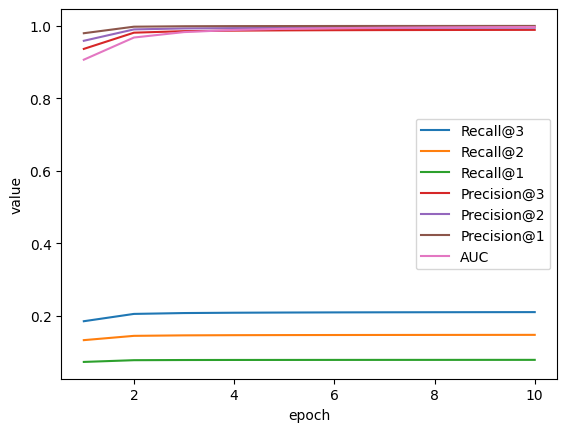

In [56]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 11)]

plt.plot(x, recall_at_3_train, label='Recall@3')
plt.plot(x, recall_at_2_train, label='Recall@2')
plt.plot(x, recall_at_1_train, label='Recall@1')
plt.plot(x, precision_at_3_train, label='Precision@3')
plt.plot(x, precision_at_2_train, label='Precision@2')
plt.plot(x, precision_at_1_train, label='Precision@1')
plt.plot(x, auc_score_train, label='AUC')

plt.xlabel('epoch')
plt.ylabel('value')

plt.legend()

plt.show()

In [50]:
# СОХРАНЯЕМ 
import pickle
with open('./optimized_models/lfm_standart_10epoch.pickle', 'wb') as fle:
    pickle.dump(lfm_model, fle, protocol=pickle.HIGHEST_PROTOCOL)

## Обучение CatBoost

### Находим кандидатов первого этапа

In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    """
    
    """
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        
        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

* Если мы уже формировали кандидатов первого этапа, то загрузим их
* Иначе сформируем кандидатов

In [15]:
# ЗАГРУЖАЕМ МОДЕЛЬ LightFM
with open('./optimized_models/lfm_standart_10epoch.pickle', 'rb') as fle:
    lfm_model = pickle.load(fle)

try:
    candidates = pd.read_csv('./data/results/candidates_lfm.csv', index_col='Unnamed: 0')
except:
    candidates = pd.DataFrame({
        'client_id': lfm_pred['client_id'].unique()
    })

    # кол-во кандидатов 
    top_N = 3

    all_cols = list(lightfm_mapping['items_mapping'].values())

    mapper = generate_lightfm_recs_mapper(
        lfm_model, 
        item_ids=all_cols, 
        known_items=dict(),
        N=top_N,
        user_features=None, 
        item_features=None, 
        user_mapping=lightfm_mapping['users_mapping'],
        item_inv_mapping=lightfm_mapping['items_inv_mapping']
    )

    # генерируем предказания
    candidates['product_id'] = candidates['client_id'].map(mapper)
    candidates = candidates.explode('product_id')
    candidates['rank'] = candidates.groupby('client_id').cumcount() + 1 

    # сохраним кандидатов
    candidates.to_csv('./data/results/candidates_lfm.csv')

    candidates.head()

### Формируем данные для обучения CatBoost

In [ ]:
# формируем позитивные взаимодействия

pos = candidates.merge(lfm_pred,
                        on=['client_id', 'product_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)

# формируем негативные примеры
neg = candidates.set_index(['client_id', 'product_id'])\
        .join(lfm_pred.set_index(['client_id', 'product_id']))

neg = neg[neg['product_quantity'].isnull()].reset_index()

neg['target'] = 0

print(neg.shape)

Производим деление по пользователям

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

ctb_train_users, ctb_test_users = train_test_split(lfm_pred['client_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [22]:
select_col = ['client_id', 'product_id', 'rank', 'target']

# формируем train
ctb_train = shuffle(
    pd.concat([
        pos[pos['client_id'].isin(ctb_train_users)],
        neg[neg['client_id'].isin(ctb_train_users)]
])[select_col]
)

# формируем test
ctb_test = shuffle(
    pd.concat([
        pos[pos['client_id'].isin(ctb_test_users)],
        neg[neg['client_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['client_id'].isin(ctb_eval_users)],
        neg[neg['client_id'].isin(ctb_eval_users)]
])[select_col]
)

### Добавляем фичи объектов и пользователей

In [25]:
user_col = ['client_id', 'age', 'gender', 'first_issue_date', 'first_redeem_date']
item_col = ['product_id', 'price_per_one', 'brand_id', 'netto', 'is_own_trademark', 'vendor_id']

In [26]:
train_feat = ctb_train.merge(clients_all[user_col],
                           on=['client_id'],
                           how='left')\
                        .merge(products_all[item_col],
                                   on=['product_id'],
                                   how='left')

eval_feat = ctb_eval.merge(clients_all[user_col],
                           on=['client_id'],
                           how='left')\
                        .merge(products_all[item_col],
                                   on=['product_id'],
                                   how='left')

### Формируем отдельно матрицу с фичами `X` и таргетами `y`

In [27]:
drop_col = ['client_id', 'product_id']
target_col = ['target']
cat_col = ['age', 'gender', 'brand_id', 'is_own_trademark', 'vendor_id']

X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1306521, 10), (1306521, 1), (145030, 10), (145030, 1))

In [28]:
X_train = X_train.fillna(X_train.mode().iloc[0])
X_train['brand_id'] = X_train['brand_id'].astype(np.int) 
X_train['vendor_id'] = X_train['vendor_id'].astype(np.int) 

X_val = X_val.fillna(X_train.mode().iloc[0])
X_val['brand_id'] = X_val['brand_id'].astype(np.int)
X_val['vendor_id'] = X_val['vendor_id'].astype(np.int)  

X_train.head()

/tmp/ipykernel_34/2508946879.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train['brand_id'] = X_train['brand_id'].astype(np.int)
/tmp/ipykernel_34/2508946879.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecate

,rank,age,gender,first_issue_date,first_redeem_date,price_per_one,brand_id,netto,is_own_trademark,vendor_id
0,1,18,1,2018-09-01 15:27:17,2019-02-12 13:08:53,66,106,0.10,0,126
1,3,28,0,2017-06-19 11:17:05,2017-09-01 13:47:55,133,139,0.18,0,164
2,2,33,0,2017-12-11 17:21:03,2019-07-25 19:19:14,58,5,0.93,0,32
3,2,50,0,2017-07-27 14:43:08,2017-12-05 13:14:54,31,1,0.68,0,1
4,3,39,2,2017-04-14 19:12:59,2017-08-23 17:57:07,77,5,0.26,0,176


## Оптимизируем CatBoost с Optuna

In [99]:
import optuna
from optuna.integration import CatBoostPruningCallback
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
import numpy as np
import joblib

def objective_catboost(trial):
    
    param = {
              'max_depth': trial.suggest_int("max_depth", 3, 10),
              'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 17),
              'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.01, 0.1),
              'n_estimators': 3000,
              'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
              'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
              'bootstrap_type': trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
            }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    ctb_model = CatBoostClassifier(**param, thread_count=-1, random_seed=42, cat_features=cat_col, verbose=-1)
    
    ctb_model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=3,
        cat_features=cat_col
    )
    
    y_pred = ctb_model.predict_proba(X_val)

    auc_score = roc_auc_score(y_val, y_pred[:, 1])

    return auc_score if auc_score != np.nan else 0.0

study_catboost = optuna.create_study(direction="maximize")

study_catboost.optimize(objective_catboost, n_trials=100, show_progress_bar=True)

print(f"Best value: {study_catboost.best_value}, Best params: {study_catboost.best_trial.params}")

# СОХРАНЯЕМ
joblib.dump(study_catboost, "./optimized_models/study_catboost_100.pkl")

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances
)

plot_param_importances(study_catboost)

In [ ]:
plot_optimization_history(study_catboost)

## Обучаем CatBoostClassifier

In [31]:
# Загрузим лучшие параметры
import joblib
study_catboost = joblib.load("./prepared_data_with_segments/study_catboost_100.pkl")
print(f"Best value: {study_catboost.best_value}, Best params: {study_catboost.best_trial.params}")

Best value: 0.6788207070088748, Best params: {'max_depth': 8, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.09737522148498104, 'learning_rate': 0.03361968845080638, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.04149029163344986}


In [35]:
from catboost import CatBoostClassifier

# подставляем параметры с лучшими значениями
est_params = {'max_depth': 8, 
              'l2_leaf_reg': 7,
              'colsample_bylevel': 0.09737522148498104, 
              'learning_rate': 0.03361968845080638, 
              'boosting_type': 'Ordered', 
              'bootstrap_type': 'Bayesian', 
              'bagging_temperature': 0.04149029163344986,
              'n_estimators': 3000,
              'random_state': 42,
              'verbose': 200
             }

ctb_model = CatBoostClassifier(**est_params)

In [36]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col,
              plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6864749	test: 0.6865138	best: 0.6865138 (0)	total: 828ms	remaining: 41m 23s
200:	learn: 0.5824517	test: 0.5836504	best: 0.5836504 (200)	total: 1m 33s	remaining: 21m 47s
400:	learn: 0.5796599	test: 0.5816157	best: 0.5816157 (400)	total: 3m 2s	remaining: 19m 42s
600:	learn: 0.5778843	test: 0.5803461	best: 0.5803458 (599)	total: 4m 23s	remaining: 17m 33s
800:	learn: 0.5769775	test: 0.5797213	best: 0.5797213 (800)	total: 5m 41s	remaining: 15m 37s
1000:	learn: 0.5760634	test: 0.5791390	best: 0.5791390 (1000)	total: 7m 6s	remaining: 14m 10s
1200:	learn: 0.5751444	test: 0.5788220	best: 0.5788164 (1197)	total: 8m 33s	remaining: 12m 49s
1400:	learn: 0.5746763	test: 0.5786380	best: 0.5786375 (1393)	total: 9m 54s	remaining: 11m 18s
1600:	learn: 0.5743791	test: 0.5785038	best: 0.5785038 (1600)	total: 11m 16s	remaining: 9m 50s
1800:	learn: 0.5740404	test: 0.5783760	best: 0.5783760 (1799)	total: 12m 41s	remaining: 8m 26s
2000:	learn: 0.5737387	test: 0.5783013	best: 0.5783013 (1999)	total

In [37]:
# СОХРАНЯЕМ МОДЕЛЬ
with open('./optimized_models/ctb_model.pickle', 'wb') as fle:
    pickle.dump(ctb_model, fle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('./optimized_models/ctb_model.pickle', 'rb') as fle:
    ctb_model = pickle.load(fle)

Оценим метрики catboost модели 

In [31]:
from sklearn.metrics import roc_auc_score

test_feat = ctb_test.merge(clients_all[user_col],
                           on=['client_id'],
                           how='left')\
                    .merge(products_all[item_col],
                               on=['product_id'],
                               how='left')

# fillna for catboost with the most frequent value 
test_feat = test_feat.fillna(X_train.mode().iloc[0])
test_feat['brand_id'] = test_feat['brand_id'].astype(np.int)
test_feat['vendor_id'] = test_feat['vendor_id'].astype(np.int) 

X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

y_pred = ctb_model.predict_proba(X_test)

print(f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}")

# Метрики качества на глобальном test

## 1. Метрики качества LightFM

In [95]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, 
                                 user_features, item_features, N, 
                                 user_mapping, item_inv_mapping, 
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, 
                             item_features=item_features, num_threads=num_threads)
        additional_N = 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]
        
        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

lfm_train, lfm_pred, test = train_valid_test_split(purchases_all)

test = test[test['client_id'].isin(lfm_train['client_id'].unique())]

lfm_prediction = pd.DataFrame({
    'client_id': test['client_id'].unique()
})

top_N = 30

all_cols = list(lightfm_mapping['items_mapping'].values())

lfm_prediction = pd.DataFrame({
    'client_id': test['client_id'].unique()
})

known_items = lfm_train.groupby('client_id')['product_id'].apply(list).to_dict()

mapper = generate_lightfm_recs_mapper(
    lfm_model, 
    item_ids=all_cols, 
    known_items=known_items,
    N=top_N,
    user_features=None, 
    item_features=None, 
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping']
)

lfm_prediction['product_id'] = lfm_prediction['client_id'].map(mapper)
lfm_prediction = lfm_prediction.explode('product_id').reset_index(drop=True)
lfm_prediction['rank'] = lfm_prediction.groupby('client_id').cumcount() + 1 

Посчитаем метрики `Precision@k`, `Recall@k`, `MAP@k`

In [114]:
def compute_metrics(df_true, df_pred, top_N, rank_col='rank'):
    result = {}
    test_recs = df_true.set_index(['client_id', 'product_id']).join(df_pred.set_index(['client_id', 'product_id']))
    test_recs = test_recs.sort_values(by=['client_id', 'rank'])

    test_recs['users_item_count'] = test_recs.groupby(level='client_id')[rank_col].transform(np.size)
    test_recs['reciprocal_rank'] = (1 / test_recs[rank_col]).fillna(0)
    test_recs['cumulative_rank'] = test_recs.groupby(level='client_id').cumcount() + 1
    test_recs['cumulative_rank'] = test_recs['cumulative_rank'] / test_recs[rank_col]
    
    users_count = test_recs.index.get_level_values('client_id').nunique()
    for k in range(1, top_N + 1):
        hit_k = f'hit@{k}'
        test_recs[hit_k] = test_recs[rank_col] <= k
        result[f'Precision@{k}'] = (test_recs[hit_k] / k).sum() / users_count
        result[f'Recall@{k}'] = (test_recs[hit_k] / test_recs['users_item_count']).sum() / users_count

    result[f'MAP@{top_N}'] = (test_recs["cumulative_rank"] / test_recs["users_item_count"]).sum() / users_count
    return pd.Series(result)

In [101]:
lfm_metrics = compute_metrics(test[['client_id', 'product_id']],
                              lfm_prediction, 
                              top_N=10)
lfm_metrics

Precision@1     0.318948
Recall@1        0.032611
Precision@2     0.320217
Recall@2        0.065575
Precision@3     0.320546
Recall@3        0.097971
Precision@4     0.320415
Recall@4        0.130283
Precision@5     0.320085
Recall@5        0.161942
Precision@6     0.318927
Recall@6        0.192926
Precision@7     0.317040
Recall@7        0.222805
Precision@8     0.314842
Recall@8        0.252025
Precision@9     0.312567
Recall@9        0.280431
Precision@10    0.310260
Recall@10       0.308230
MAP@10          0.294165
MRR             0.413650
dtype: float64

## 2. Метрики качества двухэтапной модели

In [107]:
lfm_ctb_prediction = lfm_prediction.copy()

# фичи для теста
score_feat = lfm_ctb_prediction.merge(clients_all[user_col],
                                   on=['client_id'],
                                   how='left')\
                                .merge(products_all[item_col],
                                       on=['product_id'],
                                       how='left')

# fillna for catboost with the most frequent value 
score_feat = score_feat.fillna(X_train.mode().iloc[0])
score_feat['brand_id'] = score_feat['brand_id'].astype(np.int)
score_feat['vendor_id'] = score_feat['vendor_id'].astype(np.int)  

# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

lfm_ctb_prediction['ctb_pred'] = ctb_prediction[:, 1]

# сортируем по скору внутри одного пользователя и проставляем новый ранг
lfm_ctb_prediction = lfm_ctb_prediction.sort_values(
    by=['client_id', 'ctb_pred'], ascending=[True, False])
lfm_ctb_prediction['rank_ctb'] = lfm_ctb_prediction.groupby('client_id').cumcount() + 1

# lfm_ctb_prediction.to_csv('hybrid_recommendations.csv', index=False)

/tmp/ipykernel_34/2739040929.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  score_feat['brand_id'] = score_feat['brand_id'].astype(np.int)
/tmp/ipykernel_34/2739040929.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

In [112]:
lfm_ctb_prediction.head(10)

,client_id,product_id,rank,ctb_pred,rank_ctb
1871247,0,18.0,28,0.951549,1
1871244,0,105.0,25,0.941050,2
1871241,0,92.0,22,0.910571,3
1871243,0,1.0,24,0.909944,4
1871230,0,9.0,11,0.859462,5
1871231,0,148.0,12,0.840721,6
1871223,0,281.0,4,0.811111,7
1871226,0,212.0,7,0.800445,8
1871235,0,48.0,16,0.797181,9
1871229,0,320.0,10,0.795096,10


In [115]:
model_2step_metrics = compute_metrics(test[['client_id', 'product_id']],
                                       lfm_ctb_prediction, 
                                       top_N=10, 
                                       rank_col='rank_ctb')
model_2step_metrics

Precision@1     0.808531
Recall@1        0.072926
Precision@2     0.701307
Recall@2        0.128827
Precision@3     0.614822
Recall@3        0.170598
Precision@4     0.553622
Recall@4        0.205752
Precision@5     0.510918
Recall@5        0.237894
Precision@6     0.478888
Recall@6        0.267597
Precision@7     0.453023
Recall@7        0.295135
Precision@8     0.431537
Recall@8        0.321231
Precision@9     0.413526
Recall@9        0.346478
Precision@10    0.398090
Recall@10       0.370794
MAP@10          0.697287
MRR             0.599872
dtype: float64